In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm  
import seaborn as sns
sns.set()
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv('ship_movement_analysis.csv')
df.head()

C:\Users\abasu\AppData\Local\Temp\ipykernel_12476\1183062804.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('ship_movement_analysis.csv')


,Unnamed: 0,# Timestamp,Type of mobile,MMSI,Latitude,Longitude,Navigational status,ROT,SOG,COG,...,Prev_Longitude,Distance_Travelled,Bearing,Zone,Date,Abnormal_Speed,Abnormal_Turn,Behavior_Cluster,Time_of_Day,High_Risk
0,34,2024-01-11 00:00:00,Class A,219000429,54.654167,11.350667,Under way using engine,0.0,0.4,33.2,...,11.350667,0.000000,0.000000,0,2024-01-11,0,0,3,Night,0
1,791,2024-01-11 00:00:03,Class A,219000431,54.506467,11.231333,Under way using engine,25.7,10.2,213.4,...,11.231333,0.000000,0.000000,3,2024-01-11,0,0,2,Night,0
2,1326,2024-01-11 00:00:07,Class A,219000431,54.506467,11.231333,Under way using engine,25.7,10.2,213.4,...,11.231333,0.000000,0.000000,3,2024-01-11,0,0,2,Night,0
3,1703,2024-01-11 00:00:09,Class A,211188000,54.599500,11.287417,Under way using engine,1.1,16.2,202.9,...,11.287717,0.050305,-157.375846,2,2024-01-11,0,0,2,Night,0
4,1705,2024-01-11 00:00:09,Class A,211188000,54.599500,11.287417,Under way using engine,1.1,16.2,202.9,...,11.287417,0.000000,0.000000,2,2024-01-11,0,0,2,Night,0


In [3]:
df.columns

Index(['Unnamed: 0', '# Timestamp', 'Type of mobile', 'MMSI', 'Latitude',
       'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading',
       'IMO', 'Callsign', 'Name', 'Ship type', 'Width', 'Length',
       'Type of position fixing device', 'Draught', 'Destination', 'ETA',
       'Data source type', 'A', 'B', 'C', 'D', 'Hour', 'Day_of_Week', 'Month',
       'Acceleration', 'Change_in_Heading', 'Is_Stationary', 'Is_Turning',
       'Time_To_ETA', 'Width_Length_Ratio', 'Draught_Length_Ratio',
       'Is_Abnormal_Speed', 'Suspicious_Stop', 'Prev_Latitude',
       'Prev_Longitude', 'Distance_Travelled', 'Bearing', 'Zone', 'Date',
       'Abnormal_Speed', 'Abnormal_Turn', 'Behavior_Cluster', 'Time_of_Day',
       'High_Risk'],
      dtype='object')

In [4]:
features = ["SOG", "Acceleration", "COG", "Destination", 
            "Width_Length_Ratio", "Draught_Length_Ratio", "Navigational status"]
target = "ETA"


In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder

def preprocess_data(df):
    df["ETA"] = pd.to_datetime(df["ETA"], errors="coerce")

    df["ETA_seconds"] = (df["ETA"] - pd.Timestamp.now()).dt.total_seconds()

    df = df.dropna(subset=["ETA_seconds"])

    features = ["SOG", "Acceleration", "COG", "Destination", 
                "Width_Length_Ratio", "Draught_Length_Ratio", "Navigational status"]
    
    target = "ETA_seconds"

    for col in ["SOG", "Acceleration", "COG", "Width_Length_Ratio", "Draught_Length_Ratio"]:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].median(), inplace=True)

    label_encoders = {}
    for cat_col in ["Navigational status", "Destination"]:
        if cat_col in df.columns:
            label_encoders[cat_col] = LabelEncoder()
            df[cat_col] = label_encoders[cat_col].fit_transform(df[cat_col])

    scaler = StandardScaler()
    df[["SOG", "Acceleration", "COG", "Width_Length_Ratio", "Draught_Length_Ratio"]] = scaler.fit_transform(
        df[["SOG", "Acceleration", "COG", "Width_Length_Ratio", "Draught_Length_Ratio"]])

    return df, features, target, scaler, label_encoders

df, features, target, scaler, label_encoders = preprocess_data(df)

print(df[features + [target]].head())


        SOG  Acceleration       COG  Destination  Width_Length_Ratio  \
0 -1.777314       0.00035 -0.998315            3            0.002641   
1 -0.080151       0.00035  0.879434            3            0.002641   
2 -0.080151       0.00035  0.879434            2            0.917307   
3  0.958928       0.00035  0.770020            3            0.002641   
4  0.958928       0.00035  0.770020            3            0.002641   

   Draught_Length_Ratio  Navigational status   ETA_seconds  
0              0.665181                    0 -6.703035e+06  
1              0.665181                    0 -6.703035e+06  
2              0.768530                    0 -6.703035e+06  
3              0.665181                    0 -6.703035e+06  
4              0.665181                    0 -6.703035e+06  


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² Score: {r2:.4f}")  # Should be above 0.90
print(f"Mean Absolute Error (MAE): {mae:.2f} seconds")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} seconds")


R² Score: 0.9998
Mean Absolute Error (MAE): 123.23 seconds
Root Mean Squared Error (RMSE): 275.73 seconds


In [7]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score

def categorize_eta(actual_eta, predicted_eta):
    diff = (predicted_eta - actual_eta) / 60  # Convert seconds to minutes
    if diff < -30:
        return "Early"
    elif -30 <= diff <= 30:
        return "On Time"
    else:
        return "Delayed"

y_test_class = [categorize_eta(actual, pred) for actual, pred in zip(y_test, y_pred)]
y_pred_class = [categorize_eta(actual, pred) for actual, pred in zip(y_test, y_pred)]


In [8]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test_class)
y_pred_encoded = label_encoder.transform(y_pred_class)

f1 = f1_score(y_test_encoded, y_pred_encoded, average="weighted")

conf_matrix = confusion_matrix(y_test_encoded, y_pred_encoded)

class_report = classification_report(y_test_encoded, y_pred_encoded, target_names=label_encoder.classes_)

print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)


F1 Score: 1.0000

Confusion Matrix:
 [[  162     0]
 [    0 70801]]

Classification Report:
               precision    recall  f1-score   support

       Early       1.00      1.00      1.00       162
     On Time       1.00      1.00      1.00     70801

    accuracy                           1.00     70963
   macro avg       1.00      1.00      1.00     70963
weighted avg       1.00      1.00      1.00     70963



In [9]:
import pickle

with open("eta_prediction_model.pkl", "wb") as model_fileA:
    pickle.dump(model, model_fileA)

with open("scaler.pkl", "wb") as scaler_fileA:
    pickle.dump(scaler, scaler_fileA)

with open("label_encoders.pkl", "wb") as encoders_fileA:
    pickle.dump(label_encoders, encoders_fileA)

print("Model and preprocessing tools saved successfully using pickle!")


Model and preprocessing tools saved successfully using pickle!


In [10]:
import statsmodels.api as sm


features = ["SOG", "Acceleration", "COG", "Width_Length_Ratio", 
            "Draught_Length_Ratio", "Navigational status", "Destination"]
target = "ETA_seconds"

# Drop NaN values for regression
df_ols = df.dropna(subset=features + [target]).copy()

X = df_ols[features] 
y = df_ols[target]  

X = sm.add_constant(X)

ols_model = sm.OLS(y, X).fit()

print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:            ETA_seconds   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.517e+08
Date:                Tue, 18 Mar 2025   Prob (F-statistic):               0.00
Time:                        13:57:15   Log-Likelihood:            -2.4880e+06
No. Observations:              354811   AIC:                         4.976e+06
Df Residuals:                  354804   BIC:                         4.976e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -6.677e+06 

C:\Users\abasu\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1967: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


In [11]:
df.columns

Index(['Unnamed: 0', '# Timestamp', 'Type of mobile', 'MMSI', 'Latitude',
       'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading',
       'IMO', 'Callsign', 'Name', 'Ship type', 'Width', 'Length',
       'Type of position fixing device', 'Draught', 'Destination', 'ETA',
       'Data source type', 'A', 'B', 'C', 'D', 'Hour', 'Day_of_Week', 'Month',
       'Acceleration', 'Change_in_Heading', 'Is_Stationary', 'Is_Turning',
       'Time_To_ETA', 'Width_Length_Ratio', 'Draught_Length_Ratio',
       'Is_Abnormal_Speed', 'Suspicious_Stop', 'Prev_Latitude',
       'Prev_Longitude', 'Distance_Travelled', 'Bearing', 'Zone', 'Date',
       'Abnormal_Speed', 'Abnormal_Turn', 'Behavior_Cluster', 'Time_of_Day',
       'High_Risk', 'ETA_seconds'],
      dtype='object')

In [12]:
#prediction of ship type

In [13]:
label_encoder_target = LabelEncoder()
df["Ship type"] = label_encoder_target.fit_transform(df["Ship type"])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df["Ship type"], test_size=0.2, random_state=42)

In [15]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test data
y_pred = rf_model.predict(X_test)


In [16]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", class_report)


Accuracy: 1.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     70801
           1       1.00      1.00      1.00       162

    accuracy                           1.00     70963
   macro avg       1.00      1.00      1.00     70963
weighted avg       1.00      1.00      1.00     70963



In [17]:
import pickle

with open("ship_type_model.pkl", "wb") as model_file101:
    pickle.dump(rf_model, model_file101)

with open("ship_type_label_encoder.pkl", "wb") as label_encoder_file101:
    pickle.dump(label_encoder_target, label_encoder_file101)

print("Model and encoders saved successfully!")


Model and encoders saved successfully!


In [18]:
#predicting Destination

In [19]:

features = ["SOG", "Acceleration", "COG", "Width_Length_Ratio", 
            "Draught_Length_Ratio", "Navigational status", "Ship type"]

In [20]:
df["Destination"] = (df["Destination"])

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df["Destination"], test_size=0.2, random_state=42)

In [22]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)


In [23]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", class_report)

Accuracy: 1.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     25481
           1       1.00      1.00      1.00     23813
           2       1.00      1.00      1.00     21507
           3       1.00      1.00      1.00       162

    accuracy                           1.00     70963
   macro avg       1.00      1.00      1.00     70963
weighted avg       1.00      1.00      1.00     70963



In [24]:
#Clustering

In [25]:
clustering_features = ["SOG", "ROT", "Acceleration", "Change_in_Heading", "Width_Length_Ratio"]


In [26]:
df_clustering = df.dropna(subset=clustering_features).copy()
X_clustering = df_clustering[clustering_features]  # Select only numerical features


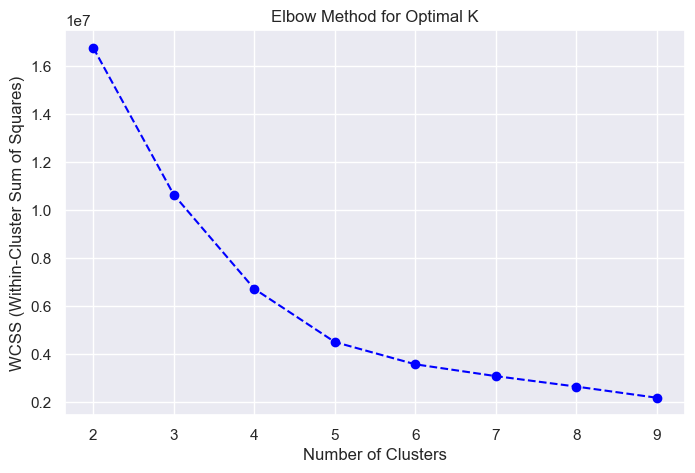

In [27]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

wcss = []
for i in range(2, 10):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(X_clustering)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(2, 10), wcss, marker='o', linestyle='dashed', color='blue')
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for Optimal K")
plt.show()


In [28]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df_clustering["Cluster"] = kmeans.fit_predict(X_clustering)

print(df_clustering["Cluster"].value_counts())


Cluster
0    297128
4     30540
3     26827
1       158
2       158
Name: count, dtype: int64


In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df_clustering["SOG"], y=df_clustering["Acceleration"], hue=df_clustering["Cluster"], palette="viridis")
plt.title("K-Means Clustering of Ships Based on Speed & Acceleration")
plt.xlabel("Speed Over Ground (SOG)")
plt.ylabel("Acceleration")
plt.legend(title="Cluster")
plt.show()
